# Effects of Bad Family Relations on Student Academics
### Introduction

Our topic, based on the dataset we chose, is to find a relationship between a student’s academics/grades and their academic history along with their number of school absences. 

Question: Can we predict G3 grades from a student's academic history and their school absences?

The data set we chose is the Student Performance Data Set, which displays student achievement in secondary education of two Portuguese schools. The data contains every kind of information of the student. It ranges from the students’ age to their alcohol consumption, to information about their parents.


### Methods
#### Libraries

In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
set.seed(1234)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

#### Reading the data set

In [3]:
temp <- tempfile()
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip", temp)
student_data <- read_csv2(unz(temp, "student-mat.csv"))
unlink(temp)
student_data

Using ',' as decimal and '.' as grouping mark. Use read_delim() for more control.

Parsed with column specification:
cols(
  .default = col_character(),
  age = col_double(),
  Medu = col_double(),
  Fedu = col_double(),
  traveltime = col_double(),
  studytime = col_double(),
  failures = col_double(),
  famrel = col_double(),
  freetime = col_double(),
  goout = col_double(),
  Dalc = col_double(),
  Walc = col_double(),
  health = col_double(),
  absences = col_double(),
  G1 = col_double(),
  G2 = col_double(),
  G3 = col_double()
)

See spec(...) for full column specifications.



school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,⋯,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GP,F,18,U,GT3,A,4,4,at_home,teacher,⋯,4,3,4,1,1,3,6,5,6,6
GP,F,17,U,GT3,T,1,1,at_home,other,⋯,5,3,3,1,1,3,4,5,5,6
GP,F,15,U,LE3,T,1,1,at_home,other,⋯,4,3,2,2,3,3,10,7,8,10
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
MS,M,21,R,GT3,T,1,1,other,other,⋯,5,5,3,3,3,3,3,10,8,7
MS,M,18,R,LE3,T,3,2,services,other,⋯,4,4,1,3,4,5,0,11,12,10
MS,M,19,U,LE3,T,1,1,other,at_home,⋯,3,2,3,3,3,5,5,8,9,9


#### Cleaning the data

In [14]:
student_tidy_data <- student_data %>%
    select(c(studytime, failures, absences, G1, G2, G3)) %>%
    mutate_at(c("studytime", "failures"), as.factor) %>%
    mutate(failures = as.numeric(failures)-1)
student_tidy_data

studytime,failures,absences,G1,G2,G3
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,0,6,5,6,6
2,0,4,5,5,6
2,3,10,7,8,10
⋮,⋮,⋮,⋮,⋮,⋮
1,3,3,10,8,7
1,0,0,11,12,10
1,0,5,8,9,9


#### Data summary

In [15]:
student_split <- initial_split(student_tidy_data, prop = 0.8)
student_train <- training(student_split)
student_test <- testing(student_split)
summary(student_train)

 studytime    failures         absences            G1              G2       
 1: 77     Min.   :0.0000   Min.   : 0.000   Min.   : 3.00   Min.   : 0.00  
 2:161     1st Qu.:0.0000   1st Qu.: 0.000   1st Qu.: 8.00   1st Qu.: 8.00  
 3: 55     Median :0.0000   Median : 4.000   Median :11.00   Median :11.00  
 4: 24     Mean   :0.3249   Mean   : 5.827   Mean   :10.94   Mean   :10.78  
           3rd Qu.:0.0000   3rd Qu.: 8.000   3rd Qu.:13.00   3rd Qu.:13.00  
           Max.   :3.0000   Max.   :75.000   Max.   :19.00   Max.   :19.00  
       G3       
 Min.   : 0.00  
 1st Qu.: 8.00  
 Median :11.00  
 Mean   :10.46  
 3rd Qu.:14.00  
 Max.   :20.00  

#### Tuning Model

In [16]:
rec <- recipe(G3 ~ G1 + G2 + failures + absences, student_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("regression")

fit <- workflow() %>%
    add_recipe(rec) %>%
    add_model(spec)    

student_vfold <- student_train %>%
    vfold_cv(v = 5, strata = G3)

gridvals <- tibble(neighbors = seq(1, 10))

fit %<>% tune_grid(resamples = student_vfold, grid = gridvals) %>%
    collect_metrics()
fit %>% filter(.metric == "rmse")

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,2.448984,5,0.1601006,Model01
2,rmse,standard,2.197103,5,0.1618006,Model02
3,rmse,standard,2.061095,5,0.1785130,Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
8,rmse,standard,2.149271,5,0.1485454,Model08
9,rmse,standard,2.130008,5,0.1434452,Model09
10,rmse,standard,2.106090,5,0.1366956,Model10


#### Finding Min

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
3,rmse,standard,2.061095,5,0.178513,Model03


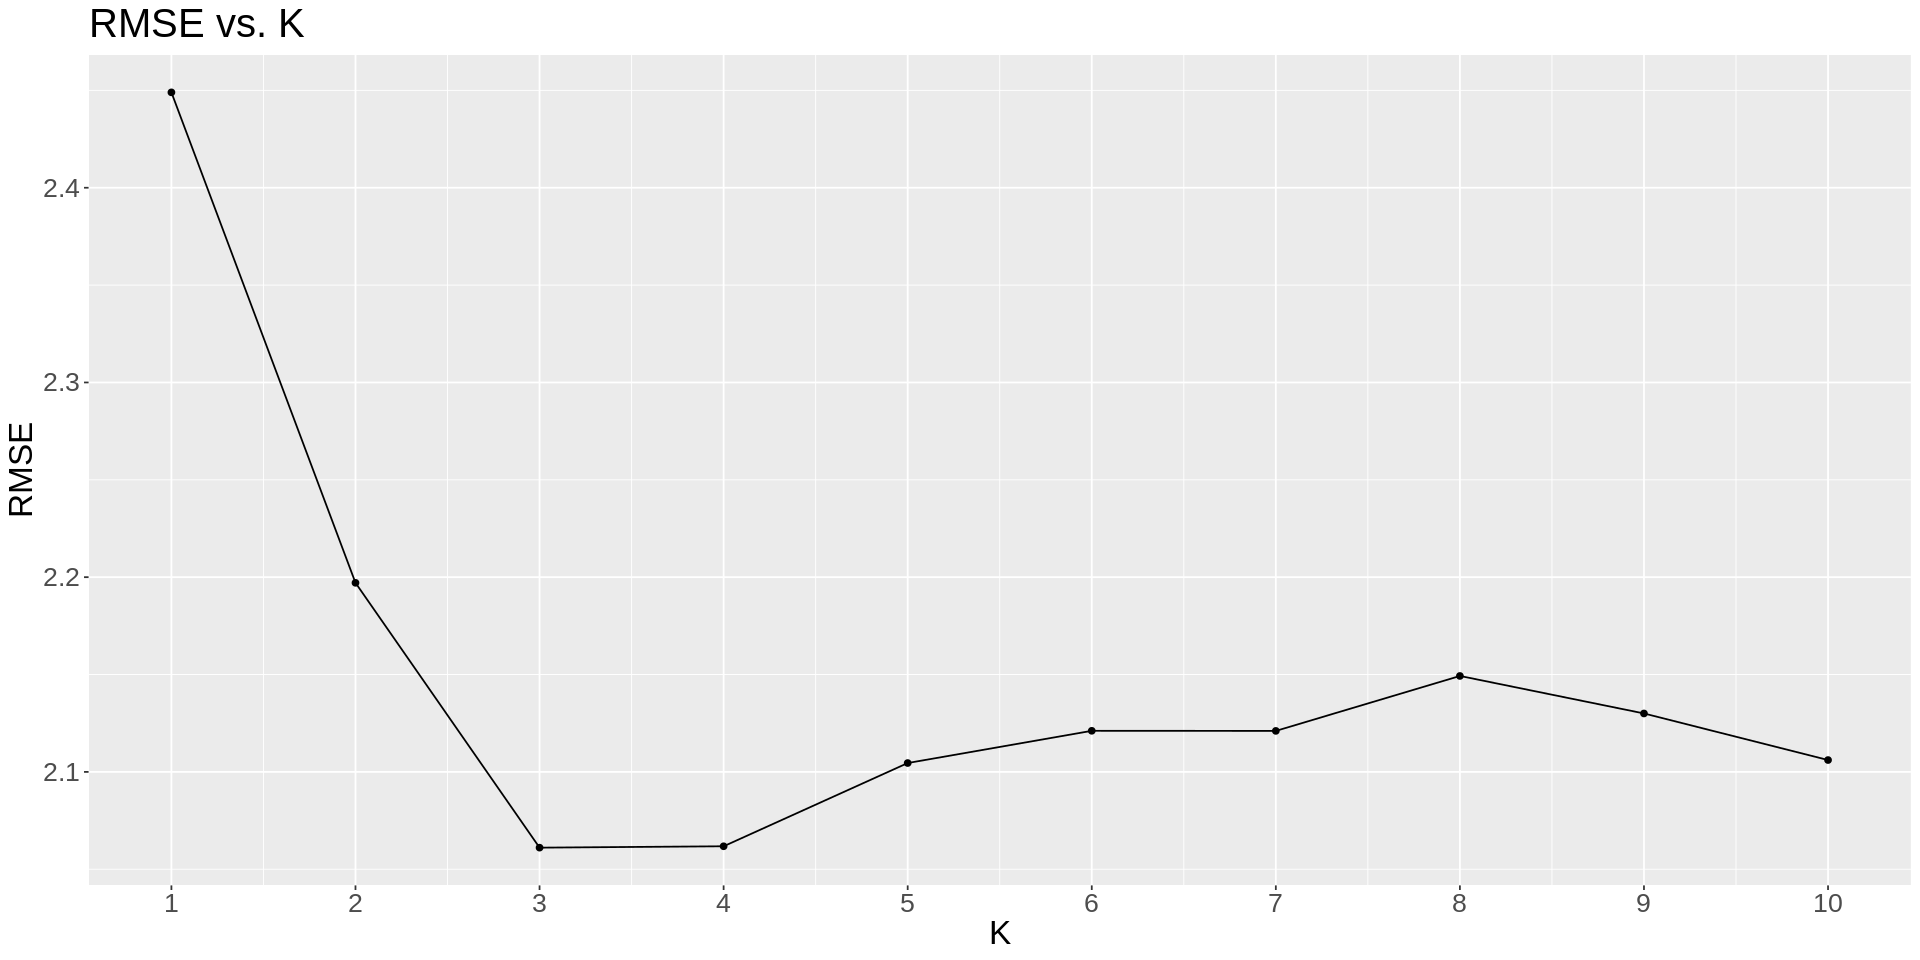

In [20]:
options(repr.plot.width = 16, repr.plot.height = 8)
accuracy_k_plot <- fit %>%
    filter(.metric == "rmse") %>%
    arrange(desc(mean)) %>%
    ggplot(aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        labs(title = "RMSE vs. K",
             x = "K",
             y = "RMSE") +
        theme(text = element_text(size = 20)) +
        scale_x_continuous(breaks = 1:10)
accuracy_k_plot

In [21]:
fit %>% filter(.metric == "rmse") %>% slice(3)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
3,rmse,standard,2.061095,5,0.178513,Model03


#### Final Model

In [18]:
student_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) %>%
    set_engine("kknn") %>%
    set_mode("regression")

student_predictions <- workflow() %>%
    add_recipe(rec) %>%
    add_model(student_spec) %>%
    fit(student_train) %>%
    predict(student_test) %>%
    bind_cols(student_test)
student_predictions %>%
    metrics(truth = G3, estimate = .pred)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,1.7316395
rsq,standard,0.8616614
mae,standard,1.1495726


### Results

For this data analysis, we chose to only look at the final grade (G3). We conducted this process using the variables; G1 (first period grades), G2 (second period grades), number of school absences, and number of past class failures. We chose these variables because it is the students' academic history that we are observing. The number of school absences is also looked at as we relate those with the other variables.
We will be performing a regression, therefore a line point plot of RMSPE vs K would display our results the best.

We first loaded and cleaned our data from its original format to a more simple and effective format that will help us with our analysis. A few functions were used to clean the data such as ```select```, ```mutate_at```, ```mutate_if```, and ```mutate```.

After we got our tidy data ready, a summary was performed on it. We first split our data into a training and a testing set with a ratio of 8:2. This ratio was chosen based on the inverse of our 5 folds.

Then, a tuning model was made. We created a model specification for K-nearest neighbours regression, along with a recipe for preprocessing the data.

A elbow-plot visualization was created for finding the minimum RMSE. We decided to make a line and point plot to display the data.

Finally, our final regression model was made; it was trained on the training data set, using $k = 3$ neighbours. We made predictions on the test data and lastly and then used the metrics function to compute the summary of the regression quality.

### Discussion

#### Summary
The results of the model gives a RMSPE of 1.73 which means that G1, G2, absences, and past failures predict G3 up to +/-1.73 of a unit of G3. Thus, we can roughly identify the final result of a student based on their past academic history but would make it difficult to ascertain which of two students of similar metrics will preform better than the other. These results only hold merit as the RMSPE of our cross-validation is not significantly different compared to that of our testing data.

#### Expectation on findings
We expected to see a correlation between the predictor and response variables because common sense dictates that a student's past grades, absences, and failures would correlate to their final grade.

#### What impact could such findings have?
We think such insight will help schools as well as parents be more prepared in helping the students succeed and get a better education. By providing students extra classes, outside of school tutors, and even give them more opportunities in their interest fields would most likely help them break away from their past grades and bad habits.

#### What future questions could this lead to?
From this data analysis, we would find out how a student's academic history along with the amount of school absences affect/impacts their studies, but what about other factors within a students’ life: how does a student's health relate to their academic education, could a student’s romantic relationship affect their studies, and how does a student’s use of their freetime contribute to their studies?

### References
At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).

https://ubc-dsci.github.io/introduction-to-datascience/index.html

Make sure to cite the source of your data as well

https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip